# Anomaly Detection in NetFlow Data

[flow_anomaly_overview](https://www.researchgate.net/publication/326146808_An_overview_of_flow-based_anomaly_detection/link/5c6516d092851c48a9d26757/download)
1. Statistical
    - monitor quantative attributes like volume of flows against thresholds. 
    - distribution based time series modeling
    - PCA (Fernandes 2015)
2. Machine learning
    - NNs, SVMs
3. Clustering
    - kmeans for botnets - derived features from flows
4. Frequent pattern mining
    - FP techniques
    - multiple different histogram based
5. Agent
    - trust model to intigrate and estimate maliciousness of flow
    - split based on proto type before applying
    

# Detectors

- blacklist_check: check srcip, dstip against known blacklist ips. can use indexing/hashing. Periodically fetch blacklists.

- flow closed check: check if tcp established connection was closed state - put in list/hash each flow tuple and maintain counter of up/dw bytes

- response check: over time repeated connection have no response - every new connection start should have response (opp srcip/dstip and ports) in T=5s. If response - remove it from list, else - observe for next time and generate alert if "too much"

- amplification detector: srcip-dstip pair based on history of number of packets/bytes (?)
- statistics detector: calculate stats for each ip - helps detect port scans, bruteforce attacks, etc. (?)
- ports usage and scanning: threshold based detector based on number of ports used
- suspicious srcip monitor: if any alert generated, enters srcip into summarizer method
- clustering
- NN


## Data Exploration

In [193]:
import pandas as pd
import ipaddress
import numpy as np

from analyzer import _FLOW_FIELDS

In [194]:
_FLOW_FIELDS

['ts',
 'ip_protocol',
 'state',
 'src_ip',
 'src_port',
 'dst_ip',
 'dst_port',
 'src_tx',
 'dst_tx']

In [195]:
df_orig = pd.read_csv("data.csv", names=_FLOW_FIELDS, parse_dates=['ts'])

In [196]:
df_orig.head()

,ts,ip_protocol,state,src_ip,src_port,dst_ip,dst_port,src_tx,dst_tx
0,2017-01-27 16:24:42,tcp,closed,10.2.1.39,60707,74.201.65.31,443,21687,8999
1,2017-01-27 16:24:42,tcp,closed,10.2.1.39,60708,74.201.65.31,443,37065,14484
2,2017-01-27 16:24:42,tcp,closed,192.168.111.106,38190,10.2.1.38,443,124834,47898
3,2017-01-27 16:24:42,tcp,closed,192.168.111.46,44178,10.2.1.39,443,0,31
4,2017-01-27 16:24:42,tcp,established,10.2.20.1,60246,10.12.0.31,80,20125,1422804


In [197]:
print(len(df_orig))

142373


In [198]:
df_orig.iloc[-1]['ts'] - df_orig.iloc[0]['ts']

Timedelta('0 days 01:10:18')

In [199]:
df_orig['ip_protocol'].unique()

array(['tcp', 'udp'], dtype=object)

In [200]:
df_orig['state'].unique()

array(['closed', 'established', 'reset', 'new', 'closing', 'connecting'],
      dtype=object)

In [201]:
print( len(df_orig['src_ip'].unique()) )
print( len(df_orig['dst_ip'].unique()) )
print( len(df_orig['src_port'].unique()) )
print( len(df_orig['dst_port'].unique()) )

218
2273
28261
474


In [202]:
print( df_orig['src_tx'].sum() )
print( df_orig['dst_tx'].sum() )

4040512881
4547933614


In [203]:
df2 = df_orig.groupby(['src_ip', 'src_port', 'dst_ip', 'dst_port', 'ip_protocol'])['state'].count().reset_index()

print("unique flows:", len(df2))

unique flows: 47334


In [204]:
#df3 = df2.copy()

#df2[ (df3['src_ip']==df2['dst_ip']) & (df3['dst_ip']==df2['src_ip']) & (df3['dst_port']==df2['src_port']) ]

## Feature Extraction

- first try: calculate with full dataset and get rid of timestamp
    - later real-time do T sec windowing (extract features every T sec and save last_state, time_first_seen)
    
- input raw features: ['ts','ip_protocol','state','src_ip','src_port','dst_ip','dst_port','src_tx','dst_tx']
- output features:
    - with (srcip, sport, dstip, dport, proto) as initial key:
    - number of entries/connections: count(entries) grouped
    - time_first_seen = ts1
    - time_last_seen = ts2
    - total time for flow (first_seen - current/end)
    - bytes_up (sum src_tx)
    - bytes_dw
    - throughput_up (total bytes/total time)
    - throughput_dw
    - first_state
    - last_state = (state)
    - state_(state) : number of connections per state
    - cidr_src_ip: get supernet string using ipaddr
    - cidr_dst_ip
    - pvt_srcip: private IPs should be declared as private (True/False)
    - pvt_dstip
    
- If group by (src_ip, dst_ip):
    - num_flows_tcp
    - num_flows_udp
    - dport_80, dport_8080, dport_443, dport_22, ... (well known ports: True/False)

#### Notes:
- Q. treat ports and ips as orthogonal features not integers?
- Q. drop flow_tuple and time stamps and try?

In [205]:
gp = df_orig.groupby(['src_ip', 'src_port', 'dst_ip', 'dst_port', 'ip_protocol'])

In [206]:
df = gp['state'].count().to_frame().rename(columns={'state':'num_conns'})

In [81]:
print("Number of individual flows :", len(df))

Number of individual flows : 47334


In [207]:
df['time_first_seen'] = gp['ts'].first()
df['time_last_seen'] = gp['ts'].last()
df['time_flow'] = (df['time_last_seen'] - df['time_first_seen']).apply(lambda x: x.seconds)

In [208]:
df['bytes_up'] = gp['src_tx'].sum()
df['bytes_dw'] = gp['dst_tx'].sum()
df['bytes_ratio'] = df['bytes_dw']/df['bytes_up']

In [209]:
df['Bps_up'] = (df['bytes_up']/df['time_flow']).fillna(-99999)
df['Bps_dw'] = (df['bytes_dw']/df['time_flow']).fillna(-99999)

In [210]:
df.head()

num_conns  \
src_ip    src_port dst_ip          dst_port ip_protocol              
0.0.0.0   68       255.255.255.255 67       udp                 87   
          5678     255.255.255.255 5678     udp                 62   
10.1.0.39 138      10.1.255.255    138      udp                  6   
10.1.1.1  5678     255.255.255.255 5678     udp                 62   
10.1.1.12 3052     255.255.255.255 3052     udp                 90   

                                                            time_first_seen  \
src_ip    src_port dst_ip          dst_port ip_protocol                       
0.0.0.0   68       255.255.255.255 67       udp         2017-01-27 16:24:45   
          5678     255.255.255.255 5678     udp         2017-01-27 16:24:58   
10.1.0.39 138      10.1.255.255    138      udp         2017-01-27 16:28:41   
10.1.1.1  5678     255.255.255.255 5678     udp         2017-01-27 16:24:58   
10.1.1.12 3052     255.255.255.255 3052     udp         2017-01-27 16:24:44   

                                                             time_last_seen  \
src_ip    src_port dst_ip          dst_port ip_protocol                       
0.0.0.0   68       255.255.255.255 67       udp         2017-01-27 17:34:30   
          5678     255.255.255.255 5678     udp         2017-01-27 17:34:58   
10.1.0.39 138      10.1.255.255    138      udp         2017-01-27 17:28:44   
10.1.1.1  5678     255.255.255.255 5678     udp         2017-01-27 17:34:58   
10.1.1.12 3052     255.255.255.255 3052     udp         2017-01-27 17:34:45   

                                                         time_flow  bytes_up  \
src_ip    src_port dst_ip          dst_port ip_protocol                        
0.0.0.0   68       255.255.255.255 67       udp               4185    153073   
          5678     255.255.255.255 5678     udp               4200     14555   
10.1.0.39 138      10.1.255.255    138      udp               3603      2610   
10.1.1.1  5678     255.255.255.255 5678     udp               4200      7242   
10.1.1.12 3052     255.255.255.255 3052     udp               4201    101520   

                                                         bytes_dw  \
src_ip    src_port dst_ip          dst_port ip_protocol             
0.0.0.0   68       255.255.255.255 67       udp                 0   
          5678     255.255.255.255 5678     udp                 0   
10.1.0.39 138      10.1.255.255    138      udp                 0   
10.1.1.1  5678     255.255.255.255 5678     udp                 0   
10.1.1.12 3052     255.255.255.255 3052     udp                 0   

                                                         bytes_ratio  \
src_ip    src_port dst_ip          dst_port ip_protocol                
0.0.0.0   68       255.255.255.255 67       udp                  0.0   
          5678     255.255.255.255 5678     udp                  0.0   
10.1.0.39 138      10.1.255.255    138      udp                  0.0   
10.1.1.1  5678     255.255.255.255 5678     udp                  0.0   
10.1.1.12 3052     255.255.255.255 3052     udp                  0.0   

                                                            Bps_up  Bps_dw  
src_ip    src_port dst_ip          dst_port ip_protocol                     
0.0.0.0   68       255.255.255.255 67       udp          36.576583     0.0  
          5678     255.255.255.255 5678     udp           3.465476     0.0  
10.1.0.39 138      10.1.255.255    138      udp           0.724396     0.0  
10.1.1.1  5678     255.255.255.255 5678     udp           1.724286     0.0  
10.1.1.12 3052     255.255.255.255 3052     udp          24.165675     0.0

In [211]:
df['first_state'] = gp['state'].first()
df['last_state'] = gp['state'].last()

In [212]:
from collections import Counter

df_state_count = gp['state'].apply(lambda x: Counter(x)).unstack().fillna(0)
df_state_count = df_state_count.rename(columns = {col: "state_"+col for col in df_state_count.columns})

In [213]:
df = df.join(df_state_count).reset_index()

In [238]:
df['cidr_src_ip'] = df['src_ip'].apply(lambda x: ipaddress.ip_network(x))
df['cidr_dst_ip'] = df['dst_ip'].apply(lambda x: ipaddress.ip_network(x))
df['pvt_src_ip'] = df['src_ip'].apply(lambda x: ipaddress.IPv4Address(x).is_private)
df['pvt_dst_ip'] = df['dst_ip'].apply(lambda x: ipaddress.IPv4Address(x).is_private)

#### add port_NUM orthogonal features (1/0)
- port_80, port_8080, port_443, port_53, port_22
- port_3306: mysql
- port_5772: rambitMQ
- port_1194: openvpn

In [262]:
# TODO: add categorical columns for famous ports/those with most connections
for port in [80, 8080, 443, 53, 22, 3306, 5772, 1194]:
    df['port_'+str(port)] = 0
    df.loc[df['dst_port']==port, 'port_'+str(port)] = 1
    
df['proto_tcp'] = 0
df.loc[df['ip_protocol']=='tcp', 'proto_tcp'] = 1

In [264]:
#df.to_pickle('df_flow_features.pkl')

# Clustering
- try DBSCAN, PCA, k-means, hierarchical

In [257]:
from matplotlib import pyplot as plt

### Try PCA
- PCA is best for continuous variables, so drop most categorical ones, leave ports and ip protocol
- no target - just seeing components to get intuition about dataset.
- Or maybe 'srcip' or 'dstip' as target (to cluster clients)
- [pca example for ref](https://www.kaggle.com/kashnitsky/topic-7-unsupervised-learning-pca-and-clustering)

In [294]:
from sklearn import decomposition
#from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

In [349]:
df.columns

Index(['src_ip', 'src_port', 'dst_ip', 'dst_port', 'ip_protocol', 'num_conns',
       'time_first_seen', 'time_last_seen', 'time_flow', 'bytes_up',
       'bytes_dw', 'bytes_ratio', 'Bps_up', 'Bps_dw', 'first_state',
       'last_state', 'state_closed', 'state_closing', 'state_connecting',
       'state_established', 'state_new', 'state_reset', 'cidr_src_ip',
       'cidr_dst_ip', 'pvt_src_ip', 'pvt_dst_ip', 'port_80', 'port_8080',
       'port_443', 'port_53', 'port_22', 'port_3306', 'port_5772', 'port_1194',
       'proto_tcp'],
      dtype='object')

In [416]:
features_max = ['src_port', 'dst_port', 'num_conns', 'time_flow', 'bytes_up', 'bytes_dw',
            'state_closed', 'state_closing', 'state_connecting',
            'state_established', 'state_new', 'state_reset', 'pvt_src_ip', 'pvt_dst_ip',
            'port_80', 'port_8080', 'port_443', 'port_53', 'port_22', 'port_3306',
            'port_5772', 'port_1194', 'proto_tcp']
features = ['num_conns', 'proto_tcp', 'time_flow', 'bytes_up', 'bytes_dw', 'state_closed',
            'state_closing', 'state_connecting', 'state_established', 'state_new', 'state_reset',
            'port_80', 'port_8080', 'port_443', 'port_53', 'port_22', 'port_3306', 'port_5772',
            'port_1194']
features_min = ['num_conns', 'time_flow', 'bytes_up', 'bytes_dw']

In [367]:
target_features = ['src_ip']

In [368]:
X = df.loc[:, features_min].values

pca = decomposition.PCA(n_components=2)
X_centered = X - X.mean(axis=0)
pca.fit(X_centered)
X_pca = pca.transform(X_centered)

print(pca.explained_variance_)
for i, component in enumerate(pca.components_):
    print("{} component: {}% of initial variance".format(i + 1, 
          round(100 * pca.explained_variance_ratio_[i], 2)))

[2.32901393e+13 2.77019698e+12]
1 component: 89.37% of initial variance
2 component: 10.63% of initial variance


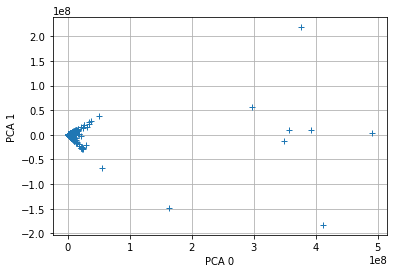

In [369]:
# Plotting the results of PCA
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot(X_pca[:, 0], X_pca[:, 1], '+')
ax.set_xlabel('PCA 0')
ax.set_ylabel('PCA 1')
ax.grid(1)

#### PCA Conclusion
- without target we can still see that with only 2 PCA components, data was already clustering

# k-means
- [k means ref](https://chrisalbon.com/machine_learning/clustering/k-means_clustering/)
- [ref 2](https://medium.com/datadriveninvestor/unsupervised-learning-with-python-k-means-and-hierarchical-clustering-f36ceeec919c)
- [ref 3](https://towardsdatascience.com/machine-learning-algorithms-part-9-k-means-example-in-python-f2ad05ed5203)
- [ref 4](https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html)

In [417]:
#from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.cluster import KMeans

In [418]:
X = df.loc[:, features_max].values
X_centered = X - X.mean(axis=0)
normalized_X = normalize(X)
X_std = StandardScaler().fit_transform(X)

In [419]:
clt = KMeans(n_clusters=5, random_state=0, n_jobs=-1)
kmeans = clt.fit(X_std)
kmeans.labels_

array([0, 0, 1, ..., 0, 1, 0], dtype=int32)

In [420]:
pred_y = kmeans.fit_predict(X_std)

In [421]:
pred_y

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

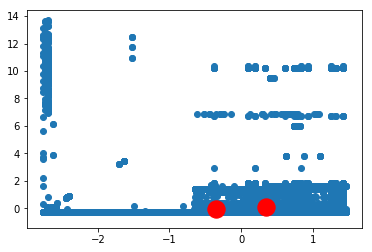

In [422]:
plt.scatter(X_std[:,0], X_std[:,1])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()

## DBSCAN
- [ref 1](https://towardsdatascience.com/dbscan-clustering-for-data-shapes-k-means-cant-handle-well-in-python-6be89af4e6ea)


In [446]:
from sklearn.cluster import DBSCAN

X = df.loc[:, features_min].values
X_std = StandardScaler().fit_transform(X)

In [447]:
dbscan = DBSCAN(eps=0.5, min_samples = 2, n_jobs=-1)
clusters = dbscan.fit_predict(X_std)

Text(0, 0.5, 'Feature 1')

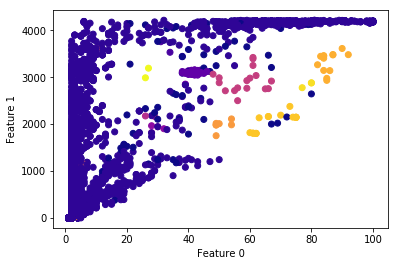

In [448]:
plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap="plasma")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

In [452]:
df['predict_dbscan'] = clusters

In [458]:
df_outliers =  df[ df['predict_dbscan']!=0 ]

In [462]:
df_outliers['src_ip'].unique()

array(['10.12.24.4', '10.2.1.20', '10.2.1.39', '10.2.20.1', '10.2.20.2',
       '10.2.20.3', '10.2.20.4', '10.2.20.5', '10.2.20.6', '10.2.20.7',
       '10.2.20.8', '10.2.254.55', '10.2.33.1', '10.2.33.4', '10.2.38.2',
       '151.237.238.125', '173.194.202.127', '177.180.108.107',
       '179.126.22.176', '192.168.100.116', '192.168.100.12',
       '192.168.100.131', '192.168.100.136', '192.168.100.15',
       '192.168.100.16', '192.168.100.173', '192.168.100.176',
       '192.168.100.181', '192.168.100.188', '192.168.100.23',
       '192.168.100.239', '192.168.100.254', '192.168.100.40',
       '192.168.100.7', '192.168.100.88', '192.168.100.96',
       '192.168.111.158', '192.168.111.226', '192.168.111.86',
       '192.168.66.246', '192.76.8.27', '199.91.71.89', '47.200.96.71',
       '66.102.1.127', '74.125.28.189', '98.207.16.69'], dtype=object)

In [485]:
df.groupby(['src_ip'])['dst_port'].unique()

src_ip
0.0.0.0                                                  [67, 5678]
10.1.0.39                                                     [138]
10.1.1.1                                                     [5678]
10.1.1.12                                                    [3052]
10.1.1.13                                                    [3052]
10.1.1.20                                                    [1900]
10.1.1.36                                                    [1900]
10.1.1.37                                                    [1900]
10.1.1.38                                                    [1900]
10.1.1.39                                                    [1900]
10.1.18.1                                                      [53]
10.1.20.1                                                    [1900]
10.1.20.10                                                   [1900]
10.1.20.11                                                   [1900]
10.1.20.2                                

In [486]:
df_outliers.groupby(['src_ip'])['dst_port'].unique()

src_ip
10.12.24.4         [39491, 53327, 41809, 46406, 47972, 44786, 404...
10.2.1.20                                                 [1194, 80]
10.2.1.39                                                      [443]
10.2.20.1                                                       [80]
10.2.20.2                                                 [1194, 80]
10.2.20.3                                                 [1194, 80]
10.2.20.4                                                 [1194, 80]
10.2.20.5                                                 [1194, 80]
10.2.20.6                                                 [80, 1194]
10.2.20.7                                                 [1194, 80]
10.2.20.8                                                     [3306]
10.2.254.55                                                   [3306]
10.2.33.1                                                      [443]
10.2.33.4                                                       [22]
10.2.38.2                  

## Neural Network

In [5]:
import tensorflow as tf